# Project 3: Spatiotemporal Analysis with Spark (v 1.0)

Report by Gudbrand Schistad, Lovedeep Singh, Nate Wilson

## Set Up

In [5]:
from math import log10

#  Note: the alphabet in geohash differs from the common base32
#  alphabet described in IETF's RFC 4648
#  (http://tools.ietf.org/html/rfc4648)
__base32 = '0123456789bcdefghjkmnpqrstuvwxyz'
__decodemap = { }
for i in range(len(__base32)):
    __decodemap[__base32[i]] = i
del i

def decode_exactly(geohash):
    """
    Decode the geohash to its exact values, including the error
    margins of the result.  Returns four float values: latitude,
    longitude, the plus/minus error for latitude (as a positive
    number) and the plus/minus error for longitude (as a positive
    number).
    """
    lat_interval, lon_interval = (-90.0, 90.0), (-180.0, 180.0)
    lat_err, lon_err = 90.0, 180.0
    is_even = True
    for c in geohash:
        cd = __decodemap[c]
        for mask in [16, 8, 4, 2, 1]:
            if is_even: # adds longitude info
                lon_err /= 2
                if cd & mask:
                    lon_interval = ((lon_interval[0]+lon_interval[1])/2, lon_interval[1])
                else:
                    lon_interval = (lon_interval[0], (lon_interval[0]+lon_interval[1])/2)
            else:      # adds latitude info
                lat_err /= 2
                if cd & mask:
                    lat_interval = ((lat_interval[0]+lat_interval[1])/2, lat_interval[1])
                else:
                    lat_interval = (lat_interval[0], (lat_interval[0]+lat_interval[1])/2)
            is_even = not is_even
    lat = (lat_interval[0] + lat_interval[1]) / 2
    lon = (lon_interval[0] + lon_interval[1]) / 2
    return lat, lon, lat_err, lon_err

def decode(geohash):
    """
    Decode geohash, returning two strings with latitude and longitude
    containing only relevant digits and with trailing zeroes removed.
    """
    lat, lon, lat_err, lon_err = decode_exactly(geohash)
    # Format to the number of decimals that are known
    lats = "%.*f" % (max(1, int(round(-log10(lat_err)))) - 1, lat)
    lons = "%.*f" % (max(1, int(round(-log10(lon_err)))) - 1, lon)
    if '.' in lats: lats = lats.rstrip('0')
    if '.' in lons: lons = lons.rstrip('0')
    return lats, lons

In [6]:
%%time
from pyspark.sql.types import StructType, StructField, FloatType, LongType, StringType
spark = SparkSession.builder.appName("Analysis").config("spark.sql.broadcastTimeout", "36000").getOrCreate()

feats = []
f = open('features.txt')
for line_num, line in enumerate(f):
    if line_num == 0:
        # Timestamp
        feats.append(StructField(line.strip(), LongType(), True))
    elif line_num == 1:
        # Geohash
        feats.append(StructField(line.strip(), StringType(), True))
    else:
        # Other features
        feats.append(StructField(line.strip(), FloatType(), True))
    
schema = StructType(feats)

nam_tiny = spark.read.format('csv').option('sep', '\t').schema(schema).load('/nam_tiny_copy.tdv')
nam_1 = spark.read.format('csv').option('sep', '\t').schema(schema).load('/nam/nam_201501.tdv.gz')
# nam_s = spark.read.format('csv').option('sep', '\t').schema(schema).load('/data/nam_s/*')
nam = spark.read.format('csv').option('sep', '\t').schema(schema).load('/nam/*')

nam_tiny.createOrReplaceTempView("nam_tiny")
nam.createOrReplaceTempView("nam")
nam_1.createOrReplaceTempView("nam_1")

CPU times: user 8.3 ms, sys: 0 ns, total: 8.3 ms
Wall time: 1.12 s


## Warm-Ups

### Unknown Feature: Choose a feature from the data dictionary above that you have never heard of before. Inspect some of the values for the feature (such as its average, min, max, etc.) and try to guess what it measures. Was your hypothesis correct? (Note: if you are a professional meteorologist, you can skip this question ;-))

In [45]:
%%time
friction_velocity_surface_min = spark.sql("SELECT MIN(friction_velocity_surface) as Min,\
                                                  MAX(friction_velocity_surface) as Max,\
                                                  AVG(friction_velocity_surface) as Avg FROM nam").show()



+-----------+---------+-----------------+
|        Min|      Max|              Avg|
+-----------+---------+-----------------+
|7.477789E-5|3.7546434|0.326961839852495|
+-----------+---------+-----------------+

CPU times: user 120 ms, sys: 58.7 ms, total: 179 ms
Wall time: 12min 24s


We choose `friction_velocity_surface` as our feature of choice. We hypothesize that it is something to with airflow. 

The statistics support that hypothesis, given that I would expect the majority of places to have low airflow, but would also expect certain windy places, for example Chicago, the windy city, to have very high airflow. 

Wikipedia defines friction velocity as:
>**Shear Velocity**, also called **friction velocity**, is a form by which a shear stress may be re-written in units of velocity. It is useful as a method in fluid mechanics to compare true velocities, such as the velocity of a flow in a stream, to a velocity that relates shear between layers of flow.



### Hot hot hot: When and where was the hottest temperature observed in the dataset? Is it an anomaly?

In [48]:
%%time
# warmup2
maxtemp = spark.sql(   "SELECT temperature_surface as MaxTemp, Timestamp/1000 TimeStamp, Geohash \
                        FROM nam \
                        WHERE temperature_surface in \
                           (SELECT MAX(temperature_surface) \
                            FROM nam)").show()

+---------+-----------+------------+
|  MaxTemp|  TimeStamp|     Geohash|
+---------+-----------+------------+
|331.39062|1.4402664E9|d5dpds10m55b|
+---------+-----------+------------+

CPU times: user 310 ms, sys: 157 ms, total: 468 ms
Wall time: 32min 29s


The geohash coordinated point to Cancum which is Mexican City on the Yucatán Peninsula bordering the Caribbean Sea and is known for its beaches, numerous resorts and nightlife. The  climate is tropical, with a muggy and rainy season from May to October, and a cooler season, and also relatively dry, from November to April. So this high temperature is an anomaly looking at the climate of the place. Below is the nice view of this beautiful city

![title](CANCUN-MINI-1200x800.jpg)


### So Snowy: Find a location that is snowy all year (there are several). Locate a nearby town/city and provide a small writeup about it. Include pictures if you’d like.



In [45]:
%%time
# Warmup 3. Getting five snowy locations
# snowysurface = spark.sql(  "SELECT  Geohash FROM nam_1  WHERE Geohash NOT IN (SELECT distinct(Geohash) FROM nam_tiny  WHERE categorical_snow_yes1_no0_surface = 0)").show(5)
# The above query was taking too long to run so had to change the query
maxdepth = spark.sql("SELECT MAX(snow_depth_surface) as maxval FROM nam").collect()
spark.sql(f"SELECT Geohash FROM nam WHERE snow_depth_surface='{maxdepth[0].maxval}'").show()

+------------+
|     Geohash|
+------------+
|f2w7rv7q5hup|
+------------+

CPU times: user 149 ms, sys: 61.5 ms, total: 210 ms
Wall time: 19min 55s


The above geohash gives us Lac-au-Brochet, QC, Canada where it snows all year. Lac-au-Brochet is an unorganized territory in the Côte-Nord region of Quebec, Canada. It makes up over 83% of the La Haute-Côte-Nord Regional County Municipality. The community of Labrieville is located approximately in the centre of the territory along the Betsiamites River. Named after Napoléon-Alexandre Labrie, bishop of the Diocese of Golfe St-Laurent, it was established in the 1950s as a work camp to accommodate Hydro-Québec workers constructing the Bersimis-1 and Bersimis-2 generating stations. The company town was fully serviced with a hospital, hotel, bank, and shopping plaza. Upon completion of the hydro-electric facilities, Hydro-Québec tried to find another buyer for the town. But this proved unsuccessful, and they transferred most houses and businesses to Forestville in 1974. The community now serves as an access point to the Labrieville ZEC.

The eponymous Brochet Lake is about 20 kilometres (12 mi) north-east of the Pipmuacan Reservoir and just over 30 kilometres (19 mi) north of Labrieville. It has a surface area of nearly 45 square kilometres (17 sq mi), and is drained by the Brochet River, a tributary of the Betsiamites. Named after the northern pike (French: brochet), the Montagnais called it Tshinusheu Shakikan, also meaning Pike Lake.

![title](snowyallyear.jpg)

## Analysis

### Strangely Snowy: Find a location that contains snow while its surroundings do not. Why does this occur? Is it a high mountain peak in a desert?

For finding the strangely snowy place fiest we find all the snow covered locations. Then we find the neighbors of each location having at least 4 similar geohash charcters. Then we print the location if it has not snowed at the neighbors during any time of the year.

In [81]:
%%time
snow_covered_locations = spark.sql("select distinct(Geohash) from nam where categorical_snow_yes1_no0_surface == 1").collect()

CPU times: user 408 ms, sys: 51.3 ms, total: 460 ms
Wall time: 17min 16s


In [82]:
%%time
for row in snow_covered_locations:
    is_snowy = False
    length = len(row.Geohash)
    substring = row.Geohash[0: 2] 
    neighbors = spark.sql(f"Select distinct(Geohash) from nam \
                                where \
                                Geohash like  '{substring}%' \ 
                                and Geohash != '{row.Geohash}'").collect()
    isneighbor = False
    for neighbor in neighbors:
        isneighbor = True
        count = spark.sql(f"SELECT count(*) \
                            FROM nam \
                            WHERE \
                                Geohash = '{neighbor.Geohash}'\
                                AND categorical_snow_yes1_no0_surface = 1 \
                            HAVING count(*) > 0").collect()
        if(len(count) > 0):
            issnowy = True
            break 
       
   
    if (is_snowy == False and isneighbor == True):
        print("strangely snowy place found")
        print("cold place " + row.Geohash)
        break;

strangely snowy place found
cold place c3ft7x0fccup
CPU times: user 120 ms, sys: 36.9 ms, total: 157 ms
Wall time: 13min 58s


The place which geohash c3ft7x0fccup points to is 'Peace River D, BC, Canada'. It is a regional district electoral area in the Peace River Regional District in northeastern British Columbia, Canada. The area is surrounded by small hills around the river due to which it snows in this small area. The other areas arounnd do not see any snowfall while it snows in this strech of the land.

![strangelysnowy](strangelysnowy.jpg)

### Lightning rod: Where are you most likely to be struck by lightning? Use a precision of at least 4 Geohash characters and provide the top 3 locations.

In [11]:
%%time

from IPython.core.display import display, HTML


lightning = spark.sql("SELECT SUBSTRING(Geohash,1,4) as geohash, \
                              count(*) as count, \
                              AVG(land_cover_land1_sea0_surface) as avgSurface \
                       FROM nam \
                       WHERE lightning_surface > 0 \
                       GROUP BY geohash \
                       ORDER BY avgSurface desc, count desc").collect()


#Get the lon and lat for the top three results. 
#Decode return lat/long
mostLikely = decode(lightning[0][0])
secondMostLikely = decode(lightning[1][0])
thirdMostLikely = decode(lightning[2][0])
print(mostLikely,secondMostLikely,thirdMostLikely)

('19', '-103') ('19', '-100') ('19', '-99')
CPU times: user 642 ms, sys: 34.1 ms, total: 676 ms
Wall time: 5min 54s


![lightning_rod](lightning_rod.png)


### Drying out: Choose a region in North America (defined by one or more Geohashes) and determine when its driest month is. This should include a histogram with data from each month.

CPU times: user 58.3 ms, sys: 6.85 ms, total: 65.2 ms
Wall time: 5min 36s


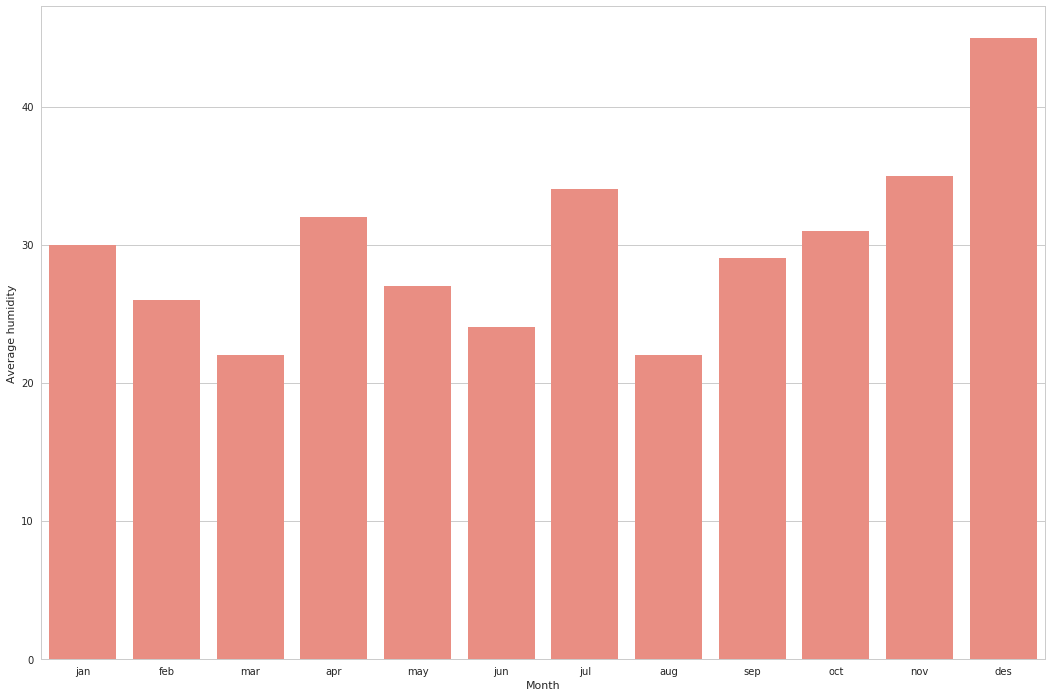

In [13]:
%%time
import seaborn as sns
import matplotlib.pyplot as plt

humid = spark.sql("SELECT MONTH(FROM_UNIXTIME(Timestamp/1000)) as month, \
                          AVG(relative_humidity_zerodegc_isotherm) as average \
                   FROM nam \
                   WHERE (Geohash LIKE '9q8yy%') \
                   GROUP BY month \
                   ORDER BY month").collect()

#Sort result by month
humid.sort()
#Create an array with the average humidity score for each month
i = 0
average_humidity_list = []
for x in humid:
    average_humidity_list.append(int(humid[i][1]))
    i += 1

#Create histogram with the result
mos = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'des']
plt.figure(figsize=(18,12))
sns.set(style="whitegrid")
ax = sns.barplot(x=mos, y=average_humidity_list, color="salmon")
ax.set(ylabel='Average humidity', xlabel='Month')

### Travel Startup: After graduating from USF, you found a startup that aims to provide personalized travel itineraries using big data analysis. Given your own personal preferences, build a plan for a year of travel across 5 locations. Or, in other words: pick 5 regions. What is the best time of year to visit them based on the dataset? One avenue here could be determining the comfort index for a region. You could incorporate several features: not too hot, not too cold, dry, humid, windy, etc. There are several different ways of calculating this available online, and you could also analyze how well your own metrics do.


In [4]:
%%time
# Travel Startup
relative_humidity_zerodegc_isotherm = 45
temperature_surface = 299
total_cloud_cover_entire_atmosphere = 60 
# Grand canyon 9qrhf6btbt3jevhn
# Panhandle san francisco 9q8yvs4t
# New york dr5regw2z6y
# Fresno 9qd23ynghrrz
# Vegas 9qqj

traveldata = spark.sql( "SELECT  \
                            substring(Geohash, 0, 4) as region, \
                            MONTH(FROM_UNIXTIME(Timestamp/1000)) as month, \
                            AVG(temperature_surface) as temperature, \
                            AVG(relative_humidity_zerodegc_isotherm) as humdity, \
                            AVG(surface_wind_gust_surface) as windspeed, \
                            AVG(total_cloud_cover_entire_atmosphere) as cloudcover \
                        FROM nam \
                        WHERE \
                            Geohash like '9qd2%' or \
                            Geohash like 'dr5r%' or \
                            Geohash like '9q8y%' or \
                            Geohash like '9qrh%' or  \
                            Geohash like '9qqj%'  \
                        GROUP BY \
                            MONTH(FROM_UNIXTIME(Timestamp/1000)), \
                            substring(Geohash, 0, 4)").collect()

CPU times: user 127 ms, sys: 58.9 ms, total: 186 ms
Wall time: 12min 52s


In [12]:
%%time
# Travel Startup
relative_humidity_zerodegc_isotherm = 45
temperature_surface = 299
total_cloud_cover_entire_atmosphere = 60 
for row in traveldata:
    isgood = True
    if(row.temperature < (temperature_surface - (temperature_surface * .12)) or  
       row.temperature > (temperature_surface + (temperature_surface * .12))):
        isgood = False
    if(row.humdity < (relative_humidity_zerodegc_isotherm - (relative_humidity_zerodegc_isotherm * .3)) or  
       row.humdity > (relative_humidity_zerodegc_isotherm + (relative_humidity_zerodegc_isotherm * .3))):
        isgood = False
    if(row.cloudcover < (total_cloud_cover_entire_atmosphere - (total_cloud_cover_entire_atmosphere * .5)) or  
       row.cloudcover > (total_cloud_cover_entire_atmosphere + (total_cloud_cover_entire_atmosphere * .5))):
        isgood = False
    if(isgood == True):
        print(f"{row.region} {row.month} ")

9qd2 12 
dr5r 6 
9qrh 10 
9qrh 1 
9q8y 12 
9q8y 10 
9q8y 7 
dr5r 12 
dr5r 7 
dr5r 5 
dr5r 10 
9q8y 4 


The five places we use for our trevel predictions are Arizona, San Francisco, New York, Fresno and Vegas. The parameters we use for prediction are temperature, cloud cover and humidity. The temperature should be within 12% range of our specified value, humidity in 30% of our value and cloud cover should be within 50% of our value.

In the first query we store the average of these values for these regions for each month. We use first four characters of Geohash to specify the region. Then we compare the average of these values with our specified criteria to make the prediction.
<pre>
The result of our travel prediction are-  
Region                Month  
Fresno(9qd2)   -->    December  
NewYork(dr5r)  -->    May, June, July, October, December  
Arizona(9qrh)  -->    January, October  
SFO(9q8y)      -->    April, July, October, December  
</pre>

The results seem pretty accurate according to the criteris we set. The only problem is we did not get any month when we should visit Vegas. It is understable because over the course of a month either it is too hoe or too cold due to which it doesnot fit into our criteria. Atleast our travel startup ccan save people a lot of money since it is never going to suggest people to visit Vegas. 	

### Escaping the fog: After becoming rich from your startup, you are looking for the perfect location to build your Bay Area mansion with unobstructed views. Find the locations that are the least foggy and show them on a map.


In [14]:
%%time
from IPython.core.display import display, HTML

fogResult = spark.sql("SELECT Geohash, \
                              AVG(visibility_surface) as visSurface, \
                              AVG(land_cover_land1_sea0_surface) as avgSurface\
                       FROM nam \
                       WHERE Geohash LIKE '9q8y%' \
                          OR Geohash LIKE '9q8z%' \
                          OR Geohash LIKE '9q9n%' \
                          OR Geohash LIKE '9q9j%' \
                       GROUP BY Geohash \
                       ORDER BY avgSurface desc, visSurface desc").collect()
cordinates_list = []
i = 0
listLength = 20
if(len(fogResult) < 20):
    listLength = len(fogResult)


for x in fogResult:
    if(i == listLength):
        break
    if(fogResult[i][2] == 1.0):
        cordinates_list.append(decode(fogResult[i][0]))
    i += 1
# headerTitle = "Top places to build Bay Area mansion with unobstructed views"
# result_map = get_location_map(headerTitle, cordinates_list)
# htmlString = result_map.replace("\n"," ").replace("\\'","'")
# display(HTML(htmlString))
print(cordinates_list)

[('37.48522', '-122.076495'), ('37.590076', '-122.103274'), ('37.568782', '-122.235539'), ('37.966215', '-122.476407'), ('37.463939', '-122.208647'), ('37.694883', '-122.130117'), ('37.716083', '-121.997675'), ('37.944666', '-122.609058'), ('37.861582', '-122.449166'), ('37.442554', '-122.340741'), ('37.652164', '-122.394841'), ('37.840047', '-122.581705')]
CPU times: user 65.8 ms, sys: 14.3 ms, total: 80.1 ms
Wall time: 13min 7s


![EscapingFog](escaping_fog.png)

### SolarWind, Inc.: You get bored enjoying the amazing views from your mansion, so you start a new company; here, you want to help power companies plan out the locations of solar and wind farms across North America. Locate the top 3 places for solar and wind farms, as well as a combination of both (solar + wind farm). You will report a total of 9 Geohashes as well as their relevant attributes (for example, cloud cover and wind speeds).


In [7]:
%%time
solarResult = spark.sql("SELECT \
                            SUBSTRING(Geohash,1,6) as prefix, \
                            AVG(CAST(total_cloud_cover_entire_atmosphere AS DECIMAL(10,2))) as cloudCover, \
                            AVG(land_cover_land1_sea0_surface) as avgSurface  \
                        FROM nam \
                        WHERE Geohash LIKE 'b%' or Geohash LIKE 'c%' or Geohash LIKE 'f%' or Geohash LIKE 'g%' or Geohash LIKE '9%' \
                        GROUP BY prefix \
                        ORDER BY avgSurface desc, cloudCover").collect()

#print(" --- Top 3 solar farm locations --- \n", solarResult.head(3))
print("---- Top three solar farms ----")
print("#1. Geohash:" + str(solarResult[0][0]) + ", Average cloud cover: " + str(solarResult[0][1]))
print("#2. Geohash:" + str(solarResult[1][0]) + ", Average cloud cover: " + str(solarResult[1][1]))
print("#3. Geohash:" + str(solarResult[2][0]) + ", Average cloud cover: " + str(solarResult[2][1]))



windResult = spark.sql("SELECT \
                            SUBSTRING(Geohash,1,6) as prefix, \
                            AVG(surface_wind_gust_surface) as avgWind, \
                            AVG(land_cover_land1_sea0_surface) as avgSurface  \
                        FROM nam \
                        WHERE Geohash LIKE 'b%' or Geohash LIKE 'c%' or Geohash LIKE 'f%' or Geohash LIKE 'g%' or Geohash LIKE '9%' \
                        GROUP BY prefix \
                        ORDER BY avgSurface desc, avgWind desc").collect()

print("---- Top three wind farms ----")
print("#1. Geohash: " + str(windResult[0][0]) + ", Average wind gust surface: " + str(windResult[0][1]))
print("#2. Geohash: " + str(windResult[1][0]) + ", Average wind gust surface: " + str(windResult[1][1]))
print("#3. Geohash: " + str(windResult[2][0]) + ", Average wind gust surface: " + str(windResult[2][1]))

maxWindSpeed = spark.sql("SELECT MAX(surface_wind_gust_surface) FROM nam").collect()

windAndSolarResult = spark.sql(f"SELECT \
                                     SUBSTRING(Geohash,1,6) as prefix, \
                                     AVG(surface_wind_gust_surface) as avgWind, \
                                     AVG(CAST(total_cloud_cover_entire_atmosphere AS DECIMAL(10,2))) as cloudCover, \
                                     AVG(land_cover_land1_sea0_surface) as avgSurface  \
                                 FROM nam \
                                 WHERE Geohash LIKE 'b%' or Geohash LIKE 'c%' or Geohash LIKE 'f%' or Geohash LIKE 'g%' or Geohash LIKE '9%' \
                                 GROUP BY prefix \
                                 ORDER BY  avgSurface desc, ((avgWind/ {maxWindSpeed[0][0]} )*100)*cloudCover desc").collect()

first = windAndSolarResult[0]
second = windAndSolarResult[1]
third = windAndSolarResult[2]

print("---- Top three wind and solar farms ----")
print("Geohash: " + str(first[0]) + ", Score: ", str(first[1]/maxWindSpeed[0][0]*100 * float((first[2]))))
print("Geohash: " + str(second[0]) + ", Score: ", str(second[1]/maxWindSpeed[0][0]*100 * float((second[2]))))
print("Geohash: " + str(third[0]) + ", Score: ", str(third[1]/maxWindSpeed[0][0]*100 * float((third[2]))))

---- Top three solar farms ----
#1. Geohash:9mtz1c, Average cloud cover: 13.301871
#2. Geohash:9mwj3j, Average cloud cover: 13.459723
#3. Geohash:9mtzhu, Average cloud cover: 13.545972
---- Top three wind farms ----
#1. Geohash: f9xnxc, Average wind gust surface: 9.800085319956015
#2. Geohash: fb26s4, Average wind gust surface: 9.725511452739502
#3. Geohash: f9yb5s, Average wind gust surface: 9.64748791203677
---- Top three wind and solar farms ----
Geohash: fb26s4, Score:  1397.8502081646964
Geohash: fb2739, Score:  1368.680043253268
Geohash: fb27hu, Score:  1367.2308668341618
CPU times: user 1.82 s, sys: 0 ns, total: 1.82 s
Wall time: 25min 9s


### Climate Chart: Given a Geohash prefix, create a climate chart for the region. This includes high, low, and average temperatures, as well as monthly average rainfall (precipitation). Here’s a (poor quality) script that will generate this for you.
Earn up to 1 point of extra credit for enhancing/improving this chart (or porting it to a more feature-rich visualization library)

In [24]:
%%time
# '9qd2' is for fresno
climatechart = spark.sql( "SELECT  \
                            MONTH(FROM_UNIXTIME(Timestamp/1000)) as month, \
                            min(temperature_surface) as mintemperature, \
                            max(temperature_surface) as maxtemperature, \
                            avg(temperature_surface) as windspeed, \
                            avg(precipitable_water_entire_atmosphere) as avgprecipitation \
                        FROM nam \
                        WHERE \
                            Geohash like '9qd2%' \
                        GROUP BY \
                            MONTH(FROM_UNIXTIME(Timestamp/1000)) order by month").collect()

CPU times: user 25.8 ms, sys: 12.9 ms, total: 38.7 ms
Wall time: 5min 53s


In [25]:
for row in climatechart:
    print(f"{row.month} {row.maxtemperature} {row.mintemperature} {row.avgprecipitation} {row.windspeed}")

1 294.53485107421875 270.47833251953125 14.215490691405906 283.8186889476022
2 300.7342529296875 274.96588134765625 15.151728175935292 288.38677397228423
3 309.3341064453125 275.3348083496094 13.908607656438052 292.30022260100105
4 311.763916015625 275.71392822265625 15.109135683592376 292.43494133476736
5 317.519775390625 279.1986083984375 16.909075073016588 295.8589065715831
6 323.783203125 282.072021484375 19.686512034238294 303.30622551127675
7 322.795654296875 284.4580078125 26.000285560316076 303.5133496894211
8 322.322509765625 282.60107421875 21.29520650098553 302.2390336720957
9 320.047607421875 280.017333984375 21.308739263848608 301.950974797628
10 312.65771484375 280.19677734375 21.658212004036738 295.51082988169003
11 298.22125244140625 270.3633117675781 12.454477379635936 283.86621256168485
12 291.885009765625 270.5841369628906 13.086391363825117 281.2947800651429


![ClimateChart](climate_chart.jpg)

### Influencers: Determine how features influence each other using Pearson’s correlation coefficient (PCC). The output for this job should include (1) feature pairs sorted by absolute correlation coefficient, and (2) a correlation matrix visualization (heatmaps are a good option).

In [28]:
%%time
import pandas as pd
import math
from pyspark.mllib.stat import Statistics

feats = []
f = open('features.txt')
for line_num, line in enumerate(f):
    if line_num > 1:
        feats.append(line)

df = sql('SELECT \
`geopotential_height_lltw`, \
`water_equiv_of_accum_snow_depth_surface`, \
`drag_coefficient_surface`, \
`sensible_heat_net_flux_surface`, \
`categorical_ice_pellets_yes1_no0_surface`, \
`visibility_surface`, \
`number_of_soil_layers_in_root_zone_surface`, \
`categorical_freezing_rain_yes1_no0_surface`, \
`pressure_reduced_to_msl_msl`, \
`upward_short_wave_rad_flux_surface`, \
`relative_humidity_zerodegc_isotherm`, \
`categorical_snow_yes1_no0_surface`, \
`u-component_of_wind_tropopause`, \
`surface_wind_gust_surface`, \
`total_cloud_cover_entire_atmosphere`, \
`upward_long_wave_rad_flux_surface`, \
`land_cover_land1_sea0_surface`, \
`vegitation_type_as_in_sib_surface`, \
`v-component_of_wind_pblri`, \
`albedo_surface`, \
`lightning_surface`, \
`ice_cover_ice1_no_ice0_surface`, \
`convective_inhibition_surface`, \
`pressure_surface`, \
`transpiration_stress-onset_soil_moisture_surface`, \
`soil_porosity_surface`, \
`vegetation_surface`, \
`categorical_rain_yes1_no0_surface`, \
`downward_long_wave_rad_flux_surface`, \
`planetary_boundary_layer_height_surface`, \
`soil_type_as_in_zobler_surface`, \
`geopotential_height_cloud_base`, \
`friction_velocity_surface`, \
`maximumcomposite_radar_reflectivity_entire_atmosphere`, \
`plant_canopy_surface_water_surface`, \
`v-component_of_wind_maximum_wind`, \
`geopotential_height_zerodegc_isotherm`, \
`mean_sea_level_pressure_nam_model_reduction_msl`, \
`temperature_surface`, \
`snow_cover_surface`, \
`geopotential_height_surface`, \
`convective_available_potential_energy_surface`, \
`latent_heat_net_flux_surface`, \
`surface_roughness_surface`, \
`pressure_maximum_wind`, \
`temperature_tropopause`, \
`geopotential_height_pblri`, \
`pressure_tropopause`, \
`snow_depth_surface`, \
`v-component_of_wind_tropopause`, \
`downward_short_wave_rad_flux_surface`, \
`u-component_of_wind_maximum_wind`, \
`wilting_point_surface`, \
`precipitable_water_entire_atmosphere`, \
`u-component_of_wind_pblri`, \
`direct_evaporation_cease_soil_moisture_surface` FROM nam')

features = df.rdd.map(lambda row: row[0:])
col_names = df.columns
scores_array = []
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)

for i in range(0, 56):
    for j in range(0, 56):
        scores_array.append((corr_mat[i,j],feats[i], feats[j]))

for y in range (0, len(scores_array)):
    if(math.isnan(scores_array[y][0])):
        scores_array.insert(y,(0,scores_array[y][1],scores_array[y][2]))
# sorting in reverse
scores_array.sort(reverse = True, key = lambda x: abs(x[0]))
print(scores_array)
# corr_df.index, corr_df.columns = col_names, col_names,

[(1.0, 'geopotential_height_lltw\n', 'geopotential_height_lltw\n'), (1.0, 'water_equiv_of_accum_snow_depth_surface\n', 'water_equiv_of_accum_snow_depth_surface\n'), (1.0, 'drag_coefficient_surface\n', 'drag_coefficient_surface\n'), (1.0, 'sensible_heat_net_flux_surface\n', 'sensible_heat_net_flux_surface\n'), (1.0, 'categorical_ice_pellets_yes1_no0_surface\n', 'categorical_ice_pellets_yes1_no0_surface\n'), (1.0, 'visibility_surface\n', 'visibility_surface\n'), (1.0, 'number_of_soil_layers_in_root_zone_surface\n', 'number_of_soil_layers_in_root_zone_surface\n'), (1.0, 'categorical_freezing_rain_yes1_no0_surface\n', 'categorical_freezing_rain_yes1_no0_surface\n'), (1.0, 'pressure_reduced_to_msl_msl\n', 'pressure_reduced_to_msl_msl\n'), (1.0, 'upward_short_wave_rad_flux_surface\n', 'upward_short_wave_rad_flux_surface\n'), (1.0, 'relative_humidity_zerodegc_isotherm\n', 'relative_humidity_zerodegc_isotherm\n'), (1.0, 'categorical_snow_yes1_no0_surface\n', 'categorical_snow_yes1_no0_surface\

[]

/home2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-seri

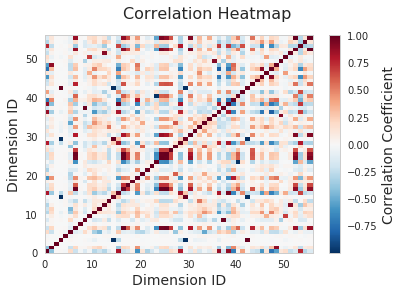

In [31]:
import sys
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

plt.suptitle('Correlation Heatmap', fontsize=16)
plt.xlabel('Dimension ID', fontsize=14)
plt.ylabel('Dimension ID', fontsize=14)

plt.pcolor(corr_mat, cmap='RdBu_r')
cb = plt.colorbar()
cb.set_label('Correlation Coefficient', fontsize=14)
plt.plot()

### Prediction/Classification: Using what you learned above as your guide, choose a feature to predict or classify via machine learning models in MLlib. You will need to explain: (1) The feature you will predict/classify (2) Features used to train the model (3) How you partitioned your data

The feature which we will be predicting is 'snow_cover_surface'.  

We used correlation to matric to find the fetures most related to snow cover surface and used those features for training our model.
<pre>
The features we used for training our model are -
1. geopotential_height_lltw
2. upward_long_wave_rad_flux_surface
3. albedo_surface
4. downward_long_wave_rad_flux_surface
5. plant_canopy_surface_water_surface
6. geopotential_height_zerodegc_isotherm
7. temperature_surface
8. snow_depth_surface
</pre>

In [9]:
%%time
# Machine learning
from pyspark.ml.feature import VectorAssembler

def prepare_data(dframe, predictors, target):
    assembler = VectorAssembler(inputCols=predictors, outputCol="features")
    output = assembler.transform(dframe)
    return output.select("features", target).withColumnRenamed(target, "label")


prepped = prepare_data(nam_tiny,
    ["geopotential_height_lltw", 
     "upward_long_wave_rad_flux_surface", 
     "albedo_surface", 
     "downward_long_wave_rad_flux_surface",
     "plant_canopy_surface_water_surface",
     "geopotential_height_zerodegc_isotherm",
     "temperature_surface",
     "snow_depth_surface"
    ],
    "snow_cover_surface")

prepped.show()
(trainingData, testData) = prepped.randomSplit([0.8, 0.2])

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[3975.03125,424.9...|  0.0|
|[-3088.21875,234....|  0.0|
|[2515.78125,430.9...|  0.0|
|[136.53125,314.05...|100.0|
|[2437.03125,427.0...|  0.0|
|[3206.28125,445.9...|  0.0|
|[4.28125,303.1810...|100.0|
|[3474.53125,422.3...|  0.0|
|[3126.03125,402.8...|  0.0|
|[3939.78125,445.3...|  0.0|
|[2788.28125,391.9...|  0.0|
|[-472.96875,291.5...|100.0|
|[3284.53125,445.0...|  0.0|
|[2062.28125,377.4...|  0.0|
|[2318.03125,405.3...|  0.0|
|[3072.03125,344.6...|100.0|
|[315.28125,315.68...|100.0|
|[3568.28125,438.8...|  0.0|
|[3369.28125,448.3...|  0.0|
|[2902.53125,332.3...|100.0|
+--------------------+-----+
only showing top 20 rows

CPU times: user 52.3 ms, sys: 4.6 ms, total: 56.9 ms
Wall time: 1.28 s


In [10]:
%%time
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(numTrees=100, maxDepth=5, maxBins=32)
model = rf.fit(trainingData)
predictions = model.transform(testData)

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 2.01227
CPU times: user 22.9 ms, sys: 1.99 ms, total: 24.8 ms
Wall time: 11 s


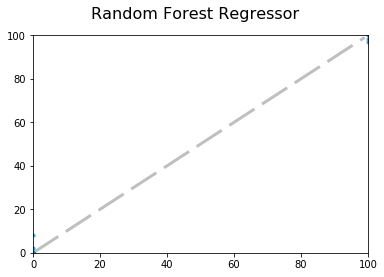

CPU times: user 90.9 ms, sys: 0 ns, total: 90.9 ms
Wall time: 1.76 s


In [11]:
%%time
%matplotlib inline

import matplotlib.pyplot as plt

p_df = predictions.select("label", "prediction").toPandas()

plt.suptitle('Random Forest Regressor', fontsize=16)

minval = p_df[['label', 'prediction']].min().min()
maxval = p_df[['label', 'prediction']].max().max()
plt.axis([minval, maxval, minval, maxval])

plt.plot(p_df['label'], p_df['prediction'], '.', color='#2ba5f1')
plt.plot(range(int(minval), int(maxval)), range(int(minval), int(maxval)), lw=3, dashes=(10, 3), color='#000000', alpha=0.25, label='Ideal Predictor')
plt.show()

#### I tried running our analysis on the big data set but got out of memory error so ran I got the results from the small data set.

## Advanced Analysis

### Describe the dataset


It is the stroke dataset of the healthcare data.Here we have clinical measurements (e.g. Hypertension, heart_disease, age, family history of disease) for a number of patients, as well as information about whether each patient has had a stroke. We could use this datset for predicting and analysing various reasons for the strokes in patients. 

The schema for the dataset is described below->

![healthdata](healthdata.jpg)


In [10]:
%%time
aa_df = spark.read.csv('hdfs://orion11:25000/train_2v.csv', inferSchema=True,header=True)

CPU times: user 2.38 ms, sys: 0 ns, total: 2.38 ms
Wall time: 2.15 s


### Outline the types of insights you hope to gain from it

From the data set we can check how the various factors affect the risk of the stroke in the patients.
The various factors we would analyze are -> 
Age,
Gender,
Occupation.
Also we would design a model which would predict the probability of the stroke using the given informtion of patients.

### Make hypotheses about what you might find


Our hypothesis for the observations we might find are ->
1. Regarding the age, the risk of stroke should increase with the increasing age.
2. I think the females should have a high risk of suffering from a stroke.
3. I think the private jobs should have the highest risk of the stroke since the work prseeure is more comapred to the public 
   sector jobs.
4. Als I hope the model is able to predict the probability of stroke with at least 90% accuracy.

### Design at least 3 “questions” (along the lines of those above) and answer them. Remember that presentation matters here.

In [11]:
%%time
aa_df.createOrReplaceTempView("aa_df")
print(aa_df)
stroke = spark.sql("SELECT distinct(stroke) FROM aa_df").collect()
print(stroke)

DataFrame[id: int, gender: string, age: double, hypertension: int, heart_disease: int, ever_married: string, work_type: string, Residence_type: string, avg_glucose_level: double, bmi: double, smoking_status: string, stroke: int]
[Row(stroke=1), Row(stroke=0)]
CPU times: user 4.14 ms, sys: 0 ns, total: 4.14 ms
Wall time: 444 ms


### Find the occupation which is most vulernale to the stroke

CPU times: user 23.3 ms, sys: 0 ns, total: 23.3 ms
Wall time: 2.21 s


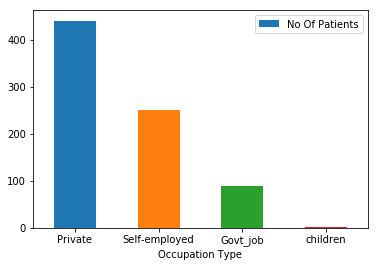

In [8]:
%%time
import pandas as pd
worktyperesult = spark.sql( "SELECT work_type, count(*) as stroke_patients \
                                FROM aa_df \
                                WHERE stroke = 1 \
                                GROUP BY work_type \
                                ORDER BY count(*) desc").collect()
worktype = []
stroke_patients = []
for i in worktyperesult:
    worktype.append(i.work_type)
    stroke_patients.append(i.stroke_patients)
df = pd.DataFrame({'Occupation Type':worktype, 'No Of Patients':stroke_patients})
ax = df.plot.bar(x='Occupation Type', y='No Of Patients', rot=0) 

CPU times: user 18.8 ms, sys: 1.84 ms, total: 20.6 ms
Wall time: 1.39 s


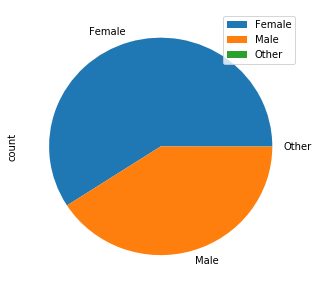

In [17]:
%%time
import pandas as pd
#Factors affecting the stroke in the people
genderresult = spark.sql( "SELECT \
                gender, \
                count(gender) as count, \
                count(gender)*100/sum(count(gender)) over() as percent \
            FROM aa_df \
            GROUP BY gender \
            order by count desc").collect()
gendercount = []
count = []
for i in genderresult:
    gendercount.append(i.gender)
    count.append(i.percent)
df = pd.DataFrame({'count': count},
                  index= gendercount)
plot = df.plot.pie(y='count', figsize=(5, 5))

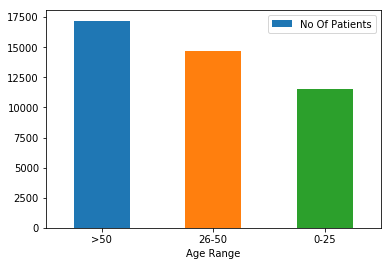

In [7]:
#Age as factor
import pandas as pd
agedata = spark.sql("SELECT case when age <= 25 then '0-25' else case when age <=50 then '26-50' else '>50' end end as age_range, \
           count(*) as stroke_count \
           FROM aa_df \
           group by 1 order by stroke_count desc").collect()
agerange = []
strokecount = []
for i in agedata:
    agerange.append(i.age_range)
    strokecount.append(i.stroke_count)
df = pd.DataFrame({'Age Range':agerange, 'No Of Patients':strokecount})
ax = df.plot.bar(x='Age Range', y='No Of Patients', rot=0) 

In [12]:
# fill in missing values
train_f = aa_df.na.fill('No Info', subset=['smoking_status'])
# fill in miss values with mean
from pyspark.sql.functions import mean
mean = train_f.select(mean(train_f['bmi'])).collect()
mean_bmi = mean[0][0]
train_f = train_f.na.fill(mean_bmi,['bmi'])

In [13]:
from pyspark.ml.feature import (VectorAssembler,OneHotEncoder,
                                StringIndexer)
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [14]:
gender_indexer = StringIndexer(inputCol='gender', outputCol = 'genderIndex')
gender_encoder = OneHotEncoder(inputCol='genderIndex', outputCol = 'genderVec')

In [15]:
ever_married_indexer = StringIndexer(inputCol='ever_married', outputCol = 'ever_marriedIndex')
ever_married_encoder = OneHotEncoder(inputCol='ever_marriedIndex', outputCol = 'ever_marriedVec')

In [16]:
work_type_indexer = StringIndexer(inputCol='work_type', outputCol = 'work_typeIndex')
work_type_encoder = OneHotEncoder(inputCol='work_typeIndex', outputCol = 'work_typeVec')

In [17]:
Residence_type_indexer = StringIndexer(inputCol='Residence_type', outputCol = 'Residence_typeIndex')
Residence_type_encoder = OneHotEncoder(inputCol='Residence_typeIndex', outputCol = 'Residence_typeVec')

In [18]:
smoking_status_indexer = StringIndexer(inputCol='smoking_status', outputCol = 'smoking_statusIndex')
smoking_status_encoder = OneHotEncoder(inputCol='smoking_statusIndex', outputCol = 'smoking_statusVec')

In [19]:
assembler = VectorAssembler(inputCols=['genderVec',
 'age',
 'hypertension',
 'heart_disease',
 'ever_marriedVec',
 'work_typeVec',
 'Residence_typeVec',
 'avg_glucose_level',
 'bmi',
 'smoking_statusVec'],outputCol='features')

In [20]:
dtc = DecisionTreeClassifier(labelCol='stroke',featuresCol='features')

In [21]:
pipeline = Pipeline(stages=[gender_indexer, ever_married_indexer, work_type_indexer, Residence_type_indexer,
                           smoking_status_indexer, gender_encoder, ever_married_encoder, work_type_encoder,
                           Residence_type_encoder, smoking_status_encoder, assembler, dtc])

In [22]:
train_data,test_data = train_f.randomSplit([0.8,0.2])

In [23]:
model = pipeline.fit(train_data)

In [24]:
dtc_predictions = model.transform(test_data)

In [25]:
acc_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
dtc_acc = acc_evaluator.evaluate(dtc_predictions)
print('Accuracy using decision tree is: {0:2.2f}%'.format(dtc_acc*100))

Accuracy using decision tree is: 98.27%


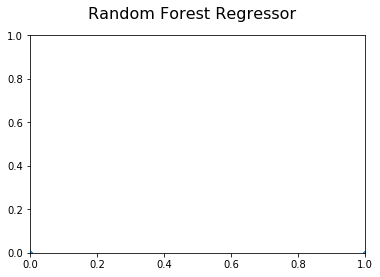

CPU times: user 137 ms, sys: 0 ns, total: 137 ms
Wall time: 769 ms


In [27]:
%%time
%matplotlib inline

import matplotlib.pyplot as plt

p_df = dtc_predictions.select("stroke", "prediction").toPandas()

plt.suptitle('Random Forest Regressor', fontsize=16)

minval = p_df[['stroke', 'prediction']].min().min()
maxval = p_df[['stroke', 'prediction']].max().max()
plt.axis([minval, maxval, minval, maxval])

plt.plot(p_df['stroke'], p_df['prediction'], '.', color='#2ba5f1')
plt.plot(range(int(minval), int(maxval)), range(int(minval), int(maxval)), lw=3, dashes=(10, 3), color='#000000', alpha=0.25, label='Ideal Predictor')
plt.show()